# Sentiment Analysis

Congrats, you finished the part on the data preparation and we can now move on to the more interesting part of using RNNs/LSTMs to process sequential data! But be careful, even if the previous notebook might seem to be a little bit boring, it is of great importance. We switched from images to text data in this exercise and remember the first steps that we did in our class were data related, too and they were essential for all the following exercises. So naturally, since we switched to text data in this exercie, make sure to have a good understanding of how the data has been prepared.

For the last I2DL exercise, we want to make use of Recurrent Neural Networks (RNNs) to process sequential data. We will stick with the same dataset that we have been looking at in the previous notebook, namely the [IMDb](https://ai.stanford.edu/~amaas/data/sentiment/) sentiment analysis dataset that contains positive and negative movie reviews.

<p class="aligncenter">
    <img src="images/IMDB.jpg" alt="centered image" />
</p>

Sentiment analysis is the task of predicting the sentiment of a text. In this notebook, you will train a network to process reviews from the dataset and evaluate whether it has been a positive or a negative review. Below are two examples:

<p class="aligncenter">
    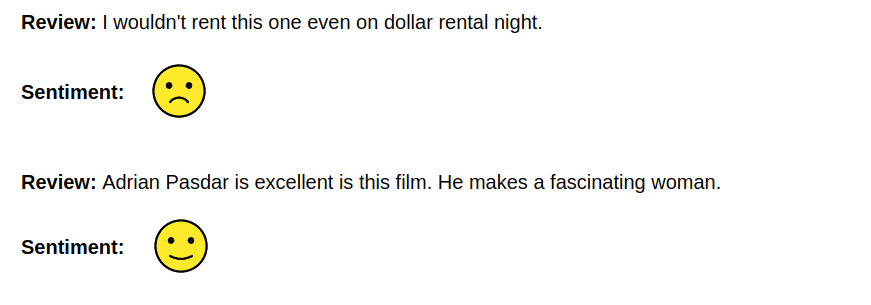
</p>


# 0. Setup

As always, we first import some packages to setup the notebook.

In [1]:
import os
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

from exercise_code.rnn.sentiment_dataset import (
    download_data,
    load_sentiment_data,
    load_vocab,
    SentimentDataset,
    collate
)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# 1. Loading Data

As we have learned from the notebook 1, this time we not only load the raw data, but also have the corresponding vocabulary. Let us load the data that we prepared for you:

In [2]:
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, "datasets", "SentimentData")
base_dir = download_data(data_root)
vocab = load_vocab(base_dir)
train_data, val_data, test_data = load_sentiment_data(base_dir, vocab)

print("number of training samples: {}".format(len(train_data)))
print("number of validation samples: {}".format(len(val_data)))
print("number of test samples: {}".format(len(test_data)))

number of training samples: 9154
number of validation samples: 3133
number of test samples: 3083


## Dataset Samples

Our raw data consists of tuples `(raw_text, token_list, token_indices, label)`. Let's sample some relatively short texts from our dataset to have a sense how it looks like:

In [3]:
sample_data0 = [datum for datum in train_data if len(datum[1]) < 20 and datum[-1] == 0] # negative
sample_data1 = [datum for datum in train_data if len(datum[1]) < 20 and datum[-1] == 1] # positive

# we sample 2 tuples each from positive set and negative set
sample_data = random.sample(sample_data0, 2) + random.sample(sample_data1, 2)
for text, tokens, indices, label in sample_data:
    print('Text: \n {}\n'.format(text))
    print('Tokens: \n {}\n'.format(tokens))
    print('Indices: \n {}\n'.format(indices))
    print('Label:\n {}\n'.format(label))
    print()

Text: 
 no comment - stupid movie, acting average or worse... screenplay - no sense at all... SKIP IT!

Tokens: 
 ['no', 'comment', 'stupid', 'movie', 'acting', 'average', 'or', 'worse', 'screenplay', 'no', 'sense', 'at', 'all', 'skip', 'it']

Indices: 
 [62, 626, 303, 13, 76, 791, 51, 335, 880, 62, 325, 31, 30, 1338, 8]

Label:
 0


Text: 
 Long, boring, blasphemous. Never have I been so glad to see ending credits roll.

Tokens: 
 ['long', 'boring', 'blasphemous', 'never', 'have', 'i', 'been', 'so', 'glad', 'to', 'see', 'ending', 'credits', 'roll']

Indices: 
 [209, 238, 1, 115, 26, 7, 90, 34, 801, 6, 55, 256, 850, 1403]

Label:
 0


Text: 
 Smallville episode Justice is the best episode of Smallville ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! 

## Checking the Vocabulary

In the previous notebook, we discussed the need of a vocabulary for mapping words to unique integer IDs. Instead of creating the vocabulary manually, we provide you with the vocabulary. Let's have a look at some samples from the vocabulary of the dataset:

In [4]:
print('Vocabulary size:', len(vocab), '\n\n  Sample words\n{}'.format('-' * 20))
sample_words = random.sample(list(vocab.keys()), 10)
for word in sample_words:
    print(' {}'.format(word))

Vocabulary size: 5002 

  Sample words
--------------------
 ten
 appropriate
 situation
 mistake
 holy
 generally
 13
 appeal
 when
 heartfelt


Also we saw that there are already indices in the raw data that we loaded. We can check if the indices in the vocabulary match the raw data using the last sentence in `sample_data`. Words that are not in the vocabulary are assigned to the symbol `<unk>`. The output of the following cell should be the same as the indices in the last example of our loaded raw data:

In [5]:
# Last sample from above 
(text, tokens, indices, label) = sample_data[-1]
print('Text: \n {}\n'.format(text))
print('Tokens: \n {}\n'.format(tokens))
print('Indices: \n {}\n'.format(indices))
print('Label:\n {}\n'.format(label))

# Compare with the vocabulary
print('Indices drawn from vocabulary: \n {}\n'.format([vocab.get(x, vocab['<unk>']) for x in sample_data[-1][1]]))

Text: 
 This is the definitive movie version of Hamlet. Branagh cuts nothing, but there are no wasted moments.

Tokens: 
 ['this', 'is', 'the', 'definitive', 'movie', 'version', 'of', 'hamlet', 'branagh', 'cuts', 'nothing', 'but', 'there', 'are', 'no', 'wasted', 'moments']

Indices: 
 [10, 9, 2, 1, 13, 304, 5, 2974, 2206, 2865, 151, 17, 44, 28, 62, 628, 385]

Label:
 1

Indices drawn from vocabulary: 
 [10, 9, 2, 1, 13, 304, 5, 2974, 2206, 2865, 151, 17, 44, 28, 62, 628, 385]



## Wrapping to PyTorch Datasets

Great, the raw data is loaded properly and the vocabulary is matching. Let us wrap our data in a PyTorch dataset. For more details, check out the previous notebook and the corresponding dataset class defined in `exercise_code/rnn/sentiment_dataset.py`.

In [6]:
#Define a Dataset Class for train, val and test set
train_dataset = SentimentDataset(train_data)
val_dataset = SentimentDataset(val_data)
test_dataset = SentimentDataset(test_data)

In [7]:
train_dataset[0]['data']

tensor([   7,  767,   34,  250,  412,   10,   13,   47,  537, 1423, 1060, 3417,
          15,  439,    4, 1247,   63,    5,    3,  171,  541,  768,  350,   12,
          10,  244,    1,  411,   39,  741,    3,  220,    2,  437,  141,    9,
         112,    2,   56,  171,   33,    4,    2,  802,  385,  721,    7,  400,
         110,   10,   13,   24,  810,   78,   34,  464,   14,    9,  138,    7,
          15,   34,  576,    6,  243,   48,    5,    2,  378, 1178, 2811,    4,
           1,    1,    7,   61,  212,   10,   13,    6,  188,   42, 4243,  152,
          50, 4016,   22, 4244,  412,    2,    1,    4,   51, 1469,   71,   22,
           2, 3699,    2,   91,  184,    6,   10,   19,    6,   63,  585,   67,
           2, 1507, 1577,    5,  353,   14, 1000,   63,  326,  147, 3861,    4,
          70,   63,  805,  209,  114,    2,  394,    5,    2,  374,   70, 1665,
           1,    2,  161, 1522,    2, 1321,    5,    2,  800, 2651,  135,   55,
           8,    4,   26,    3,   33,  3

# 2. Creating a Sentiment Classifier

After we have loaded the data, it is time to define a model and start training and testing.

## Evaluation Metrics

Since we just need to predict positive or negative, we can use `binary cross-entropy loss` to train our model. And accuracy can be used to assess our model's performance. We will use the following evaluation model to compute the accuracy.

In [8]:
bce_loss = nn.BCELoss()

@torch.no_grad()
def compute_accuracy(model, data_loader):
    corrects = 0
    total = 0
    device = next(model.parameters()).device
    
    for i, x in enumerate(data_loader):
        input = x['data'].to(device)
        lengths = x['lengths']
        label = x['label'].to(device)
        pred = model(input, lengths)
        corrects += ((pred > 0.5) == label).sum().item()
        total += label.numel()
        
        if i > 0  and i % 100 == 0:
            print('Step {} / {}'.format(i, len(data_loader)))
    
    return corrects / total

## Step 1: Design your own model

In this part, you need to create a classifier using the LSTM and Embedding layers you implemented in the previous section. For the LSTM, you may also use the PyTorch implementation.

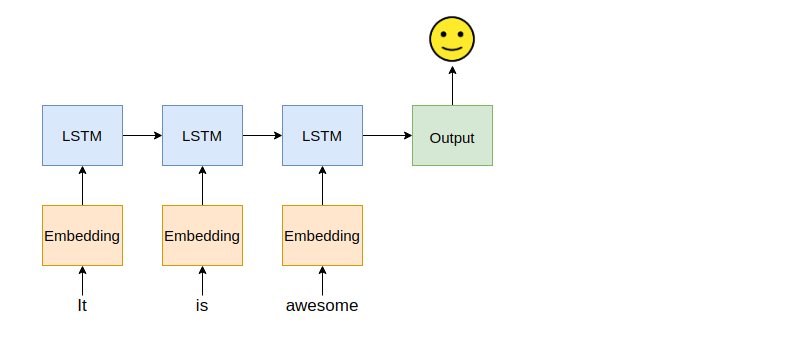



<div class="alert alert-info">
    <h3>Task: Implement a Classifier</h3>
    
   Go to <code>exercise_code/rnn/text_classifiers.py</code> and implement the <code>RNNClassifier</code>. In the skeleton code, we inherited <code>nn.Module</code>. You can also inherit <code>LightningModule</code> if you want to use PyTorch Lightning.
</div>

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically). 
The only rules your model design has to follow are:
* Inherit from `torch.nn.Module` or `pytorch_lightning.LightningModule`
* Perform the forward pass in `forward()`.
* Have less than 2 million parameters
* Have a model size of less than 50MB after saving

After you finished, edit the below cell to make sure your implementation is correct. You should define the model yourself, which should be small enough (2 Mio. parameters) and have correct output format.

In [22]:
from exercise_code.rnn.tests import classifier_test, parameter_test
from exercise_code.rnn.text_classifiers import RNNClassifier

model = None

########################################################################
# TODO - Create a Model                                               #
########################################################################

num_embeddings = len(vocab)
embedding_dim = 100
hidden_size = 512
num_layers = 10
model = RNNClassifier(num_embeddings, embedding_dim, hidden_size)

########################################################################
#                           END OF YOUR CODE                           #
########################################################################


# Check whether your model is sufficiently small and have a correct output format
parameter_test(model), classifier_test(model, len(vocab))

Total number of parameters: 1758185
Your model is sufficiently small :)
All output tests are passed :)!


(True, True)

## Step 2: Train your own model

In this section, you need to train the classifier you created. Below, you can see some setup code we provided to you. Note the **collate function** used with the `DataLoader`. If you forgot why we need the collate function here, check this out in Notebook 1.

You are free to change the below configs (e.g. batch size, device setting etc.) as you wish.

In [23]:
# Training configs
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using {}...\n'.format(device))

# Move model to the device we are using
model = model.to(device)

# To tackle with the exploding gradient problem, you may want to set gclip and use clip_grad_norm_
# see the optional notebook for the explanation
gclip = None

# Dataloaders, note the collate function
train_loader = DataLoader(
  train_dataset, batch_size=16, collate_fn=collate, drop_last=True
)
val_loader = DataLoader(
  val_dataset, batch_size=16, collate_fn=collate, drop_last=False
)

Using cuda...



<div class="alert alert-info">
<h3>Task: Implement Training</h3>
    <p>
        In the below cell, you are expected to implement your training loop to train your model. You can use the training loader provided above for iterating over the data. If you want to evaluate your model periodically, you may use the validation loader provided above. You can use pure PyTorch or PyTorch Lightning.
   </p>
</div>

**Hints :**
* Use `torch.nn.BCELoss` as loss function
* Revise the previous exercises if you get stuck.


In [24]:
########################################################################
#                     TODO - Train Your Model                          #
########################################################################
model = model.to(device)

# To tackle with the exploding gradient problem, you may want to set gclip and use clip_grad_norm_
# see the optional notebook for the explanation
gclip = None

batch_size = 16
# Dataloaders, note the collate function
train_loader = DataLoader(
  train_dataset, batch_size=batch_size, collate_fn=collate, drop_last=True
)
val_loader = DataLoader(
  val_dataset, batch_size=batch_size, collate_fn=collate, drop_last=False
)

In [25]:
device

device(type='cuda')

In [27]:
import torch.optim as optim

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 80], gamma=0.25)
len(train_loader)

572

In [28]:
#for i, x in enumerate(train_loader):
    #print(x)
    #print(x['data'].shape)  # seqence len x batchsize

In [29]:
bce_loss = nn.BCELoss()
def run_epoch(model, optimizer, dataloader, train):
    
    if train:
        model.train()
    else:
        model.eval()
    
    
    running_loss = 0.0
    #epoch_score = 0.0
   
    for i, x in enumerate(train_loader):        
        input_seq = x['data']
        label = x['label']
        lengths = x['lengths']
        
        input_seq = input_seq.to(device)
        label = label.to(device)
        #lengths.to(device)
       
        # forward
        if train:
            optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            predict = model(input_seq, lengths)
            loss = criterion(predict, label)
        
            if train:
            # backward
                loss.backward()
                optimizer.step()
           
        # statistics
        running_loss += loss.item()
   
    running_loss = running_loss / (len(dataloader) * batch_size)
    return running_loss

In [32]:
import copy
train_loss_history = []
val_loss_history = []

def fit(model, optimizer, lr_scheduler, train_dataloader, val_dataloader, max_epochs, patience): #lr_scheduler, patience
    

    best_loss = 10
    
    for epoch in range(max_epochs):
        train_loss = run_epoch(model, optimizer, train_dataloader, train=True)
        lr_scheduler.step()
        val_loss = run_epoch(model, None, val_dataloader, train=False)
        #print("Epoch: ", epoch, "train loss: %.2e", train_loss, "val loss: %.2e", val_loss)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        
        print("[Epoch %d, train loss: %.2e, val loss: %.2e" % (epoch+1, train_loss, val_loss))
        if val_loss <= best_loss:
            best_epoch = epoch
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
                
        # Early stopping
        if epoch - best_epoch >= patience:
            break
            
    model.load_state_dict(best_model_weights)

In [33]:
fit(model, optimizer, lr_scheduler, train_loader, val_loader, max_epochs=100, patience=10)
#lr_scheduler

[Epoch 1, train loss: 4.16e-02, val loss: 1.23e-01
[Epoch 2, train loss: 3.57e-02, val loss: 6.43e-02
[Epoch 3, train loss: 2.08e-02, val loss: 3.61e-02
[Epoch 4, train loss: 1.24e-02, val loss: 2.41e-02
[Epoch 5, train loss: 6.58e-03, val loss: 1.35e-02
[Epoch 6, train loss: 3.66e-03, val loss: 7.02e-03
[Epoch 7, train loss: 2.64e-03, val loss: 3.97e-03
[Epoch 8, train loss: 1.46e-03, val loss: 1.95e-03
[Epoch 9, train loss: 8.73e-04, val loss: 2.26e-03
[Epoch 10, train loss: 5.49e-04, val loss: 3.91e-04
[Epoch 11, train loss: 9.86e-05, val loss: 9.74e-05
[Epoch 12, train loss: 2.52e-05, val loss: 3.70e-05
[Epoch 13, train loss: 9.02e-06, val loss: 1.65e-05
[Epoch 14, train loss: 4.78e-06, val loss: 1.01e-05
[Epoch 15, train loss: 3.04e-06, val loss: 6.64e-06
[Epoch 16, train loss: 2.04e-06, val loss: 4.50e-06
[Epoch 17, train loss: 1.39e-06, val loss: 3.10e-06
[Epoch 18, train loss: 9.65e-07, val loss: 2.16e-06
[Epoch 19, train loss: 6.75e-07, val loss: 1.51e-06
[Epoch 20, train loss

## Testing the Model

As you trained a model and improved it on the validation set, you can now test it on the test set.

In [34]:
test_loader = DataLoader(
  test_dataset, batch_size=8, collate_fn=collate, drop_last=False
)

print("accuracy on test set: {}".format(compute_accuracy(model, test_loader)))

Step 100 / 386
Step 200 / 386
Step 300 / 386
accuracy on test set: 0.860525462212131


## Demo

Now that you trained a sufficiently good sentiment classifier, run the below cell and type some text to see some predictions (type exit to quit the demo). Since we used a small data, don't expect too much :).

In [19]:
from exercise_code.rnn.sentiment_dataset import tokenize

text = ''
w2i = vocab
while True:
    text = input()
    if text == 'exit':
        break

    words = torch.tensor([
        w2i.get(word, w2i['<unk>'])
        for word in tokenize(text)
    ]).long().to(device).view(-1, 1)  # T x B

    pred = model(words).item()
    sent = pred > 0.5
    
    print('Sentiment -> {}, Confidence -> {}'.format(
        ':)' if sent else ':(', pred if sent else 1 - pred
    ))
    print()

KeyboardInterrupt: Interrupted by user

# 3. Submission

If you got sufficient performance on the test data, you are ready to upload your model to the [server](https://dvl.in.tum.de/teaching/submission/) . As always, let's first save your final model.

In [ ]:
from exercise_code.util.save_model import save_model

save_model(model, 'rnn_classifier.p')

Congrats, you finished the last I2DL exercise! One last time this semester, let's prepare the submission:

In [ ]:
# Now zip the folder for upload
from exercise_code.util.submit import submit_exercise

submit_exercise('exercise11')

# Submission Goals

- Goal: Implement and train a recurrent neural network for sentiment analysis.
- Passing Criteria: Reach **Accuracy >= 83%** on __our__ test dataset. The submission system will show you your score after you submit.

- Submission start: __Thursday, February 4, 2021 - 12:00__
- Submission deadline: __Wednesday, February 10, 2021 - 15:59__ 
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus.